In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Take a video for 30 seconds from raspberry pi camera and save it into Test_Data directory in mp4 format
os.system('raspivid -t 30000 -o Test_Data/test_video.mp4')

In [ ]:

def extract_frames(video_path, output_folder, frames_per_second=5):

    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    count = 0

    while cap.isOpened():
        frame_id = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        ret, frame = cap.read()

        if not ret:
            print("End of video reached or error encountered.")
            break

        if frame_id % round(frame_rate / frames_per_second) == 0:
            filename = os.path.join(output_folder, f"frame_{count:04d}.jpg")
            cv2.imwrite(filename, frame)
            print(f"Saved: {filename}")
            count += 1

    cap.release()
    print(f"Extracted {count} frames from {video_path}.")

for video in os.listdir('../clips/Normal'):
    if video.endswith('.mp4'):
        video_path = os.path.join('../clips/Normal', video)
        output_folder = os.path.join('Normal_Frames', video.split('.')[0])
        extract_frames(video_path, output_folder, frames_per_second=5)


In [5]:
# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Traverse directories
        for label, class_name in enumerate(['Assault_Frames', 'Normal_Frames']):
            class_dir = os.path.join(root_dir, class_name)
            for subdir in os.listdir(class_dir):
                subdir_path = os.path.join(class_dir, subdir)
                if os.path.isdir(subdir_path):
                    for img_name in os.listdir(subdir_path):
                        img_path = os.path.join(subdir_path, img_name)
                        if img_path.endswith(('.jpg', '.jpeg', '.png')):
                            self.image_paths.append(img_path)
                            self.labels.append(label)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [6]:
# Define paths
train_dir = 'Train_Data'
test_dir = 'Test_Data'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [7]:
# Datasets and data loaders
train_dataset = CustomImageDataset(root_dir=train_dir, transform=transform)
test_dataset = CustomImageDataset(root_dir=test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
# lightweight CNN model
class LightweightCNN(nn.Module):
    def __init__(self):
        super(LightweightCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 1)      
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.global_avg_pool(x)
        x = x.view(-1, 64) 
        x = self.sigmoid(self.fc(x))
        return x


In [9]:
# Initialize model, loss function, and optimizer
model = LightweightCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check if GPU is available and move model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


LightweightCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval() 
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [13]:
# Training loop
num_epochs = 3
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculated average training loss
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Calculated training and testing accuracy
    train_accuracy = calculate_accuracy(train_loader, model)
    test_accuracy = calculate_accuracy(test_loader, model)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Calculated testing loss
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')


Epoch [1/3], Train Loss: 0.3124, Test Loss: 0.6182, Train Accuracy: 95.35%, Test Accuracy: 62.61%
Epoch [2/3], Train Loss: 0.1188, Test Loss: 0.2231, Train Accuracy: 96.96%, Test Accuracy: 93.17%
Epoch [3/3], Train Loss: 0.0738, Test Loss: 0.2491, Train Accuracy: 97.49%, Test Accuracy: 90.64%


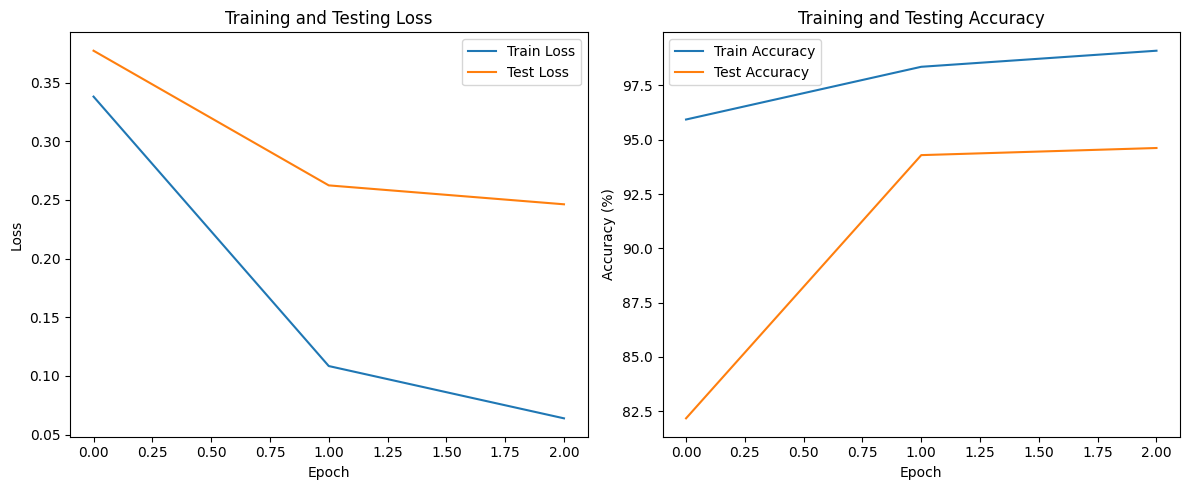

In [10]:
# Plot training and testing loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [56]:
def predict_frame(image_path, model, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Move the image to the device
    image = image.to(device)

    # Make prediction
    with torch.no_grad():
        output = model(image)
        prediction = output.item()

    return prediction  # Return the raw output for analysis

In [70]:
# Directory containing frames of an assault video
assault_frames_dir = 'Test_Data/Assault_Frames/Assault020_x264'

# Get a list of frame files
frame_files = [os.path.join(assault_frames_dir, f) 
               for f in sorted(os.listdir(assault_frames_dir)) 
               if f.endswith(('.jpg', '.jpeg', '.png'))]

# Predict each frame and aggregate results
predictions = []
for frame in frame_files:
    prediction = predict_frame(frame, model, transform, device)
    predictions.append(prediction)
    print(f'{frame}: {"Assault Detected" if prediction > 0.35 else "Normal"}')

# Aggregate results (e.g., majority vote or average prediction score)
average_score = sum(predictions) / len(predictions)
print(f'Average prediction score for the video: {average_score :.2f}')
print('Overall video prediction:', 'Assault Detected' if average_score > 0.70 else 'Normal')


Test_Data/Assault_Frames/Assault020_x264\frame_0000.jpg: Normal
Test_Data/Assault_Frames/Assault020_x264\frame_0001.jpg: Normal
Test_Data/Assault_Frames/Assault020_x264\frame_0002.jpg: Normal
Test_Data/Assault_Frames/Assault020_x264\frame_0003.jpg: Normal
Test_Data/Assault_Frames/Assault020_x264\frame_0004.jpg: Assault Detected
Test_Data/Assault_Frames/Assault020_x264\frame_0005.jpg: Assault Detected
Test_Data/Assault_Frames/Assault020_x264\frame_0006.jpg: Assault Detected
Test_Data/Assault_Frames/Assault020_x264\frame_0007.jpg: Assault Detected
Test_Data/Assault_Frames/Assault020_x264\frame_0008.jpg: Assault Detected
Test_Data/Assault_Frames/Assault020_x264\frame_0009.jpg: Assault Detected
Test_Data/Assault_Frames/Assault020_x264\frame_0010.jpg: Assault Detected
Test_Data/Assault_Frames/Assault020_x264\frame_0011.jpg: Assault Detected
Test_Data/Assault_Frames/Assault020_x264\frame_0012.jpg: Normal
Test_Data/Assault_Frames/Assault020_x264\frame_0013.jpg: Assault Detected
Test_Data/Assa

In [37]:
import os
import datetime
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText


if average_score > 0.65:
    # Created a log file with current date and time
    log_filename = 'Assault020_x264_log.txt'
    current_datetime = datetime.datetime.now()
    log_content = (
        f'Video: Assault020_x264\n'
        f'Prediction Score: {average_score:.2f}\n'
        f'Date: {current_datetime:%Y-%m-%d}\n'
        f'Time: {current_datetime:%H:%M:%S}\n'
    )
    
    # Write the log file
    try:
        with open(log_filename, 'w') as log_file:
            log_file.write(log_content)
        print(f'Log file {log_filename} created successfully.')
    except Exception as e:
        print(f'Error creating log file: {e}')
    
    # Email configuration
    sender_email = 'saroosh.hammad421@gmail.com'  # Use environment variables for security
    receiver_email = 'saroosh.hammad421@gmail.com' 
    password = os.getenv('EMAIL_PASSWORD')  # Fetch the email password from environment variables

    # Email the log file
    message = MIMEMultipart()
    message['From'] = sender_email
    message['To'] = receiver_email
    message['Subject'] = 'Assault Detection Alert'
    
    body = (
        'The video "Assault020_x264" has been detected as an assault video with a high confidence score. '
        'Please review the attached log file for details.'
    )
    message.attach(MIMEText(body, 'plain'))

    # Attach the log file
    try:
        with open(log_filename, 'r') as file:
            attachment = MIMEText(file.read())
            attachment.add_header('Content-Disposition', 'attachment', filename=log_filename)
            message.attach(attachment)
    except Exception as e:
        print(f'Error attaching log file: {e}')

    # Send the email
    try:
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
            server.login(sender_email, password)
            server.send_message(message)
        print('Email sent successfully!')
    except Exception as e:
        print(f'Error sending email: {e}')
